In [1]:
import hf00
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from IPython.display import display, Audio
import os
import torchaudio.transforms as T
import librosa
import pandas as pd
import torch

In [2]:
aud_sample = '../../LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0050.wav'
spectro_fn = T.Spectrogram(power=None)
inv_spectro_fn = T.InverseSpectrogram()

audio, label = hf00.get_random_audio_sec(aud_sample)

aud_spec = spectro_fn(audio)
label_spec = spectro_fn(label)
aud_new = inv_spectro_fn(aud_spec)

In [4]:
aud_spec.shape, label_spec.shape

(torch.Size([1, 201, 81]), torch.Size([1, 201, 81]))

In [3]:
class audioDataset(Dataset):

    def __init__(self, audio_df, audio_dir):
        #self.audio_df = pd.read_csv(audio_csvfile)
        self.audio_df = audio_df
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_dir, self.audio_df.iloc[index, 0])

        audio, label = hf00.get_random_audio_sec(audio_path)

        audio_spec = spectro_fn(audio)
        label_spec = spectro_fn(label)

        return audio_spec.real, label_spec.real

In [4]:
aud_dir = '../../LibriVox_Kaggle/'
train_df = pd.read_csv('only_audioFname_train.csv')
test_df = pd.read_csv('only_audioFname_test.csv')

train_df = train_df[2000:4000]
test_df = test_df[500:1000]

train_dataset = audioDataset(train_df,audio_dir=aud_dir)
test_dataset = audioDataset(test_df,audio_dir=aud_dir)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class SpecAE(nn.Module):

    def __init__(self):
        super(SpecAE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=1,padding=1),
            #nn.LeakyReLU()
            )

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1,padding=1),
            nn.LeakyReLU(),
    
            nn.Sigmoid()
            )
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)

        return x

In [6]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

model = SpecAE()
model.load_state_dict(torch.load('specAEmodel00.pt'))
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

#model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
epochs = 10

for epoch in range(0,epochs):

    for data in train_dataloader:
        
        model.train()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, inputs)

        # BP and optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {loss.item()}")


Epoch [1/10] Loss: 11.718469619750977
Epoch [2/10] Loss: 9.876015663146973
Epoch [3/10] Loss: 8.505707740783691
Epoch [4/10] Loss: 24.05731964111328
Epoch [5/10] Loss: 15.303425788879395
Epoch [6/10] Loss: 19.36176109313965
Epoch [7/10] Loss: 66.00719451904297
Epoch [8/10] Loss: 5.6551313400268555
Epoch [9/10] Loss: 19.25908660888672
Epoch [10/10] Loss: 33.5278205871582


In [55]:
sample = '../../LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0063.wav'
aud, ll = hf00.get_random_audio_sec(sample)

aud_spec = spectro_fn(aud)
ll_spec = spectro_fn(ll)

model = model.cpu()
model.eval()
with torch.inference_mode():
    pred_spec = model(aud_spec.real)

new_y_spec = torch.complex(pred_spec, ll_spec.imag)
new_y = inv_spectro_fn(new_y_spec)

display(Audio(aud, rate=16000))
display(Audio(new_y, rate=16000))


/tmp/ipykernel_393371/1230773547.py:9: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(ll_spec_np, ref=np.max),
/tmp/ipykernel_393371/1230773547.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(new_y_spec_np, ref=np.max),
/tmp/ipykernel_393371/1230773547.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(aud_spec_np, ref=np.max),


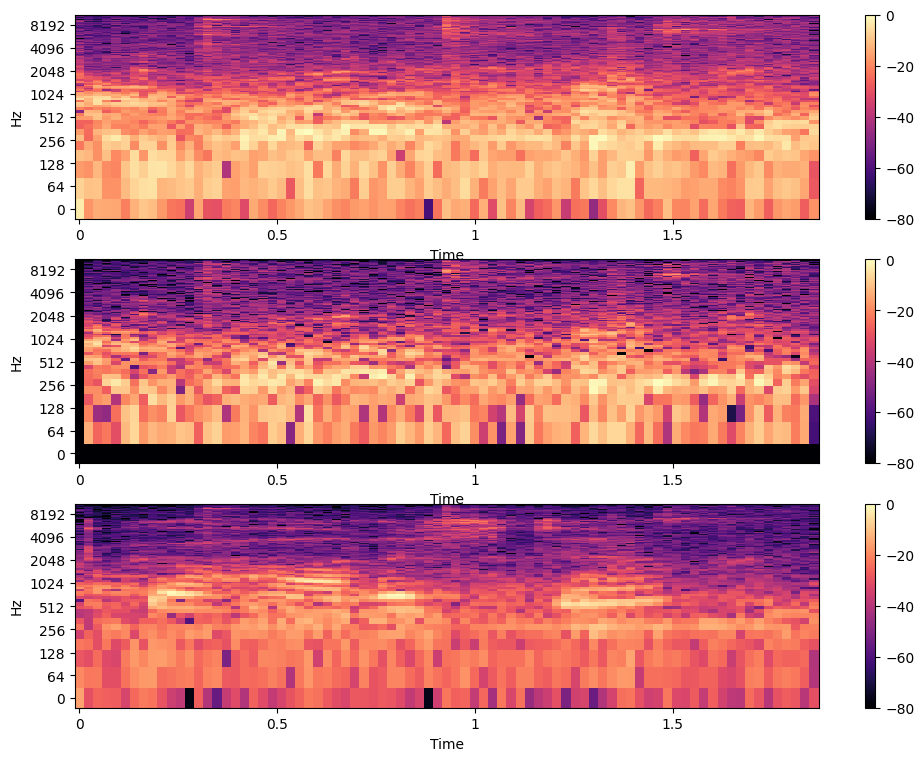

In [56]:
import matplotlib.pyplot as plt
#ll_spec.shape
ll_spec_np = ll_spec.squeeze().numpy()
new_y_spec_np = new_y_spec.squeeze().numpy()
aud_spec_np = aud_spec.squeeze().numpy()

plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
librosa.display.specshow(librosa.amplitude_to_db(ll_spec_np, ref=np.max),
                         y_axis='log', x_axis='time')

plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(librosa.amplitude_to_db(new_y_spec_np, ref=np.max),
                         y_axis='log', x_axis='time')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(librosa.amplitude_to_db(aud_spec_np, ref=np.max),
                         y_axis='log', x_axis='time')

plt.colorbar()


In [50]:
import torchaudio
import random

kitch_sample = 'Vanessa_Kitchen_Sample.wav'

kitch_aud, sr = torchaudio.load(kitch_sample)
duration = (int)(kitch_aud.shape[1]/sr)

rand_sec = random.choice([i for i in range(0, duration-1)])
start_sample = rand_sec*sr
end = (rand_sec+1)*sr

kitch_aud_ = kitch_aud[:,start_sample:end]
kitch_spec = spectro_fn(kitch_aud_)

model.eval()
with torch.inference_mode():
    pred_spec = model(kitch_spec.real)

pred_spec_full = torch.complex(pred_spec, kitch_spec.imag)
pred_aud = inv_spectro_fn(pred_spec_full)

display(Audio(kitch_aud_, rate=sr))
display(Audio(pred_aud, rate=sr))
